Load dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [ ]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['dataset.zip']), 'r')
data.extractall()

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input, RandomFlip, RandomBrightness, RandomContrast, Rescaling,
    Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras import backend as k

In [ ]:
# --- PARÂMETROS ---
dataset_dir = 'dataset/'
img_size = 224
seed = 1000
n_splits = 5
batch_size = 16
epochs = 50

In [ ]:
image_paths = []
labels = []
class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
class_map = {name: i for i, name in enumerate(class_names)}

print(f"Classes encontradas: {class_map}")

for class_name, class_idx in class_map.items():
    class_dir = os.path.join(dataset_dir, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg')):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

Classes encontradas: {'bleached_corals': 0, 'healthy_corals': 1}


In [ ]:
def create_model():
    k.clear_session()
    data_augmentation = Sequential([
        RandomFlip(mode="horizontal", seed=seed),
        RandomBrightness(factor=0.2, seed=seed),
        RandomContrast(factor=0.2, seed=seed)
    ])

    model = Sequential([
        Input(shape=(img_size, img_size, 3)),
        data_augmentation,
        Rescaling(1./255),
        Conv2D(filters=32, kernel_size=(5, 5), activation="relu", kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=192, kernel_size=(5, 5), activation="relu", kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=832, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.4),
        Dense(units=320, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.3),
        Dense(units=704, activation="relu", kernel_initializer="he_normal"),
        Dense(units=1, activation="sigmoid")
    ])

    optimizer = Adam(learning_rate=1e-4)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model

In [ ]:
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [img_size, img_size])
    image.set_shape([img_size, img_size, 3])
    return image, label

In [ ]:
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

val_loss_per_fold = []
val_accuracy_per_fold = []
val_precision_per_fold = []
val_recall_per_fold = []
f1_per_fold = []
total_cm = np.zeros((len(class_names), len(class_names)))

In [ ]:
# Configura o layout da figura para os subplots dos folds
# Calcule o número de linhas e colunas para os subplots
n_cols = 3 # Número de colunas desejadas, ajuste conforme preferir
n_rows = (n_splits + n_cols - 1) // n_cols # Garante linhas suficientes
plt.figure(figsize=(n_cols * 6, n_rows * 5)) # Ajuste o tamanho da figura conforme necessário

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>


--- Fold 1/5 ---
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 181ms/step - accuracy: 0.6313 - loss: 1.5621 - precision: 0.6427 - recall: 0.6433 - val_accuracy: 0.6087 - val_loss: 0.9998 - val_precision: 0.8846 - val_recall: 0.1933
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6897 - loss: 1.3318 - precision: 0.6850 - recall: 0.6679 - val_accuracy: 0.6285 - val_loss: 1.2479 - val_precision: 0.8378 - val_recall: 0.2605
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.7124 - loss: 1.2296 - precision: 0.6883 - recall: 0.6390 - val_accuracy: 0.7115 - val_loss: 0.7861 - val_precision: 0.8194 - val_recall: 0.4958
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.7373 - loss: 1.0308 - precision: 0.7162 - recall: 0.7306 - val_accuracy: 0.6838 - val_loss: 1.1985 - val_precision: 0.8545 - val_recall: 0.3950
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.7178 - loss: 1.0996 - precision: 0.6890 - recall: 0.6819 - val_accuracy: 0.6680

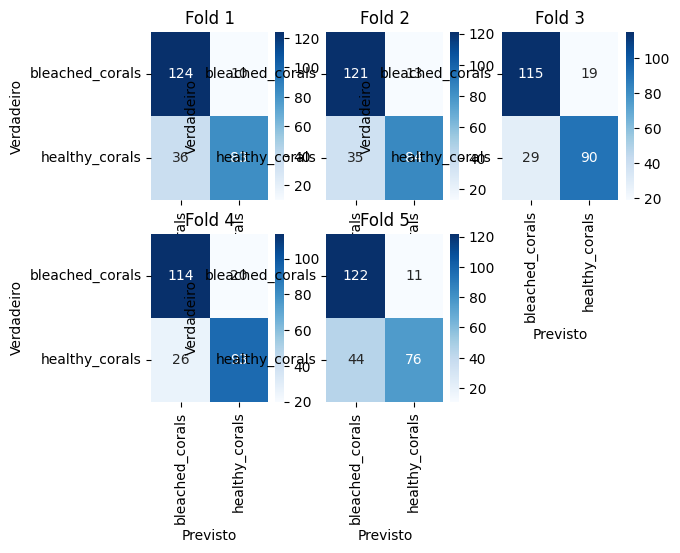

In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    train_paths, val_paths = image_paths[train_idx], image_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

    train_ds = (train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(buffer_size=len(train_paths))
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))
    val_ds = (val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(batch_size)
              .prefetch(tf.data.AUTOTUNE))

    model = create_model()
    checkpoint_path = f"best_model_fold_{fold+1}.keras"

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        mode='max', # 'max' para acurácia, 'min' para perda
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )

    best_epoch_index = np.argmax(history.history['val_accuracy']) if 'val_accuracy' in history.history else -1
    if best_epoch_index == -1: # fallback para perda se acurácia não estiver disponível ou for monitorada
        best_epoch_index = np.argmin(history.history['val_loss'])

    val_loss = history.history['val_loss'][best_epoch_index]
    val_acc = history.history['val_accuracy'][best_epoch_index]
    val_prec = history.history.get('val_precision', [None])[best_epoch_index]
    val_rec = history.history.get('val_recall', [None])[best_epoch_index]

    val_loss_per_fold.append(val_loss)
    val_accuracy_per_fold.append(val_acc)
    val_precision_per_fold.append(val_prec)
    val_recall_per_fold.append(val_rec)

    f1 = 2 * (val_prec * val_rec) / (val_prec + val_rec + 1e-7) if val_prec is not None and val_rec is not None else None
    f1_per_fold.append(f1)

    print(f"Score for fold {fold+1}: Loss={val_loss:.4f}; Accuracy={val_acc:.4f}; Precision={val_prec:.4f}; Recall={val_rec:.4f}; F1-Score={f1:.4f}")

    y_pred_probs = model.predict(val_ds)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

    y_true_list = []
    for _, y_batch in val_ds:
        y_true_list.append(y_batch.numpy())
    y_true = np.concatenate(y_true_list, axis=0)


    # Gráfico de Confusão para o fold atual como um subplot
    cm = confusion_matrix(y_true, y_pred)
    total_cm += cm # Acumula a matriz de confusão

    plt.subplot(n_rows, n_cols, fold + 1) # (linhas, colunas, índice do subplot)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.title(f'Fold {fold+1}')

In [ ]:
plt.tight_layout() # Ajusta automaticamente os parâmetros do subplot para evitar sobreposição
plt.suptitle('Matriz de confusão por fold', y=1.02, fontsize=16) # Título geral para os subplots
plt.show()

<Figure size 640x480 with 0 Axes>

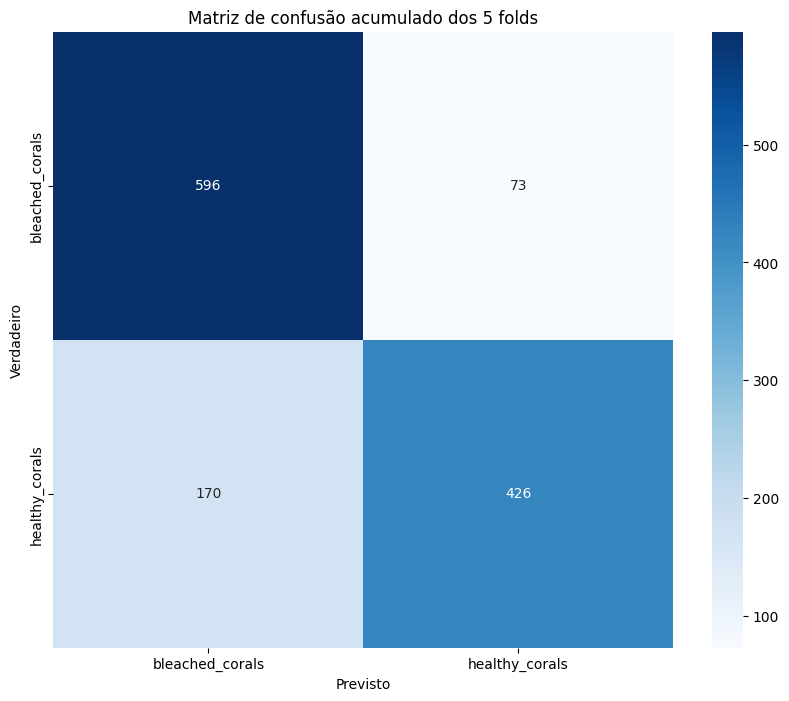

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(total_cm, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão acumulado dos 5 folds')
plt.show()


Resultados Finais da Validação Cruzada K-Folds
Acurácia: Média=0.8079 (+/- 0.0131)
Precisão: Média=0.8561 (+/- 0.0274)
Recall: Média=0.7149 (+/- 0.0514)
F1-Score: Média=0.7773 (+/- 0.0229)
Loss: Média=0.5725 (+/- 0.1186)


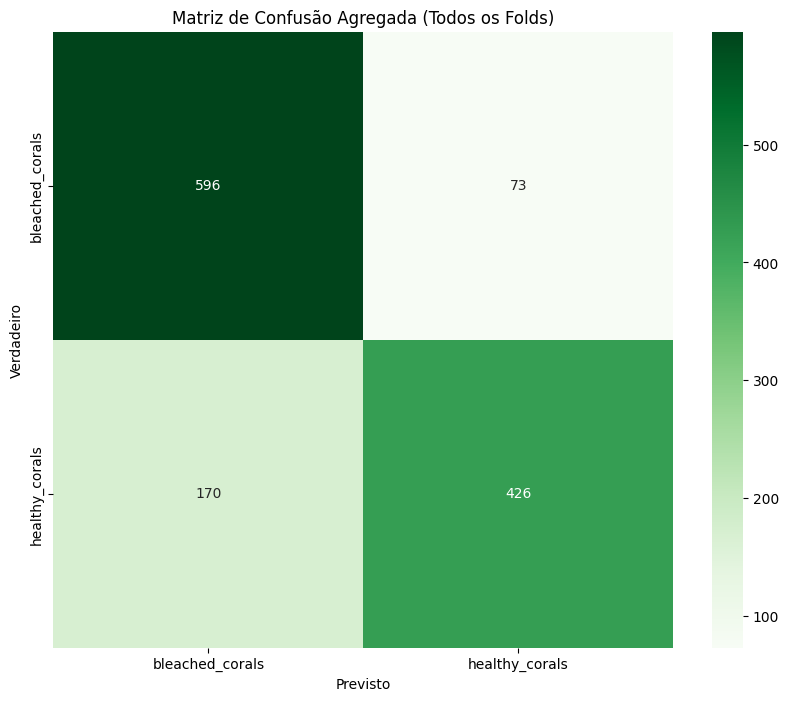

In [ ]:
print("\n" + "="*50)
print("Resultados Finais da Validação Cruzada K-Folds")
print("="*50)

def print_metric_summary(name, values):
    mean = np.mean(values)
    std = np.std(values)
    print(f"{name}: Média={mean:.4f} (+/- {std:.4f})")

print_metric_summary("Acurácia", val_accuracy_per_fold)
print_metric_summary("Precisão", val_precision_per_fold)
print_metric_summary("Recall", val_recall_per_fold)
print_metric_summary("F1-Score", f1_per_fold)
print_metric_summary("Loss", val_loss_per_fold)

plt.figure(figsize=(10, 8))
sns.heatmap(total_cm.astype(int), annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão Agregada (Todos os Folds)')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

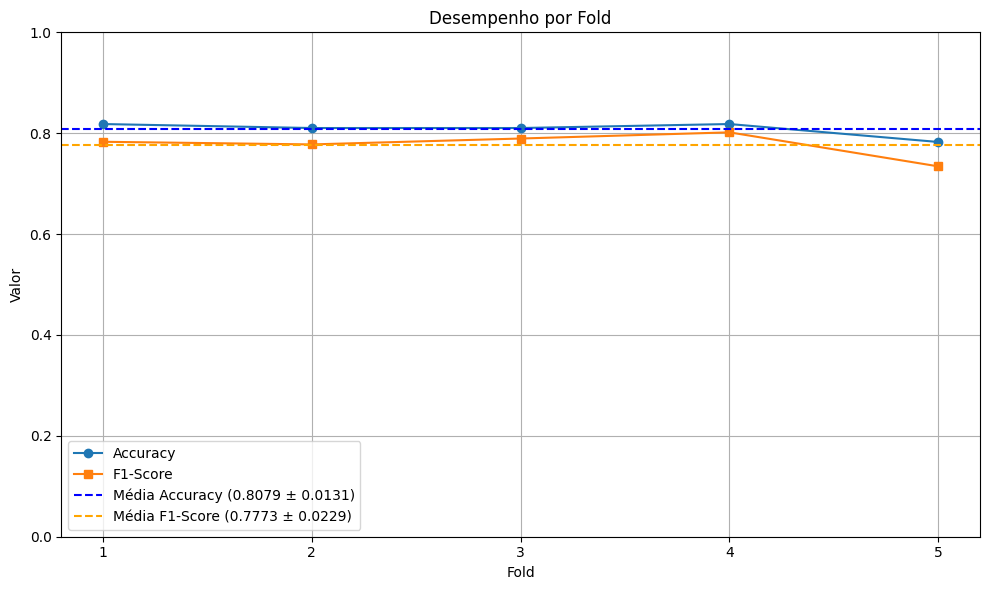

In [ ]:
folds = np.arange(1, n_splits + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(folds, val_accuracy_per_fold, marker='o', label='Accuracy')
plt.plot(folds, f1_per_fold, marker='s', label='F1-Score')

# Média e desvio padrão como linhas horizontais
mean_acc = np.mean(val_accuracy_per_fold)
std_acc = np.std(val_accuracy_per_fold)
mean_f1 = np.mean(f1_per_fold)
std_f1 = np.std(f1_per_fold)

plt.axhline(mean_acc, color='blue', linestyle='--', label=f'Média Accuracy ({mean_acc:.4f} ± {std_acc:.4f})')
plt.axhline(mean_f1, color='orange', linestyle='--', label=f'Média F1-Score ({mean_f1:.4f} ± {std_f1:.4f})')

plt.title('Desempenho por Fold')
plt.xlabel('Fold')
plt.ylabel('Acurácia')
plt.xticks(folds)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()